# Clustering

Now that the data has been processed (see `data_exploration.ipynb`), it's time to do some actual analysis!

### Table of contents
- [Clustering Comments](#clustering-comments)
- [Clustering Subreddits](#clustering-subreddits)
- [Plotting Topics](#plotting-topics)
- [Cluster Analysis](#cluster-analysis)
- [Big Data](#big-data)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF, LatentDirichletAllocation
from collections import Counter
from scipy import stats

sns.set_theme()

## Clustering Comments

To start, let's pull in the data from data_exploration.ipynb

In [2]:
comments = pd.read_pickle("../private/top_100_processed.pkl")

Now vectorize it so we can cluster it!

In [3]:
vectorizer = TfidfVectorizer(max_features=10000, min_df=2, max_df=0.5, stop_words="english")
comments_tfidf = vectorizer.fit_transform(comments.text)

Now to try to see if there are any clusters...

In [4]:
svd_model = TruncatedSVD(n_components=2)
comments_svd = svd_model.fit_transform(comments_tfidf)

In [5]:
comments_svd.shape

(118299, 2)

<Axes: >

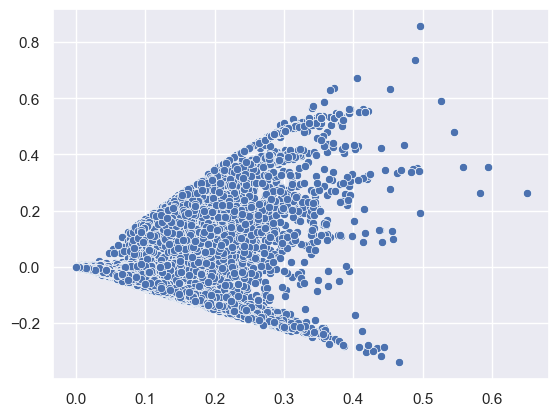

In [6]:
sns.scatterplot(x=comments_svd[:, 0], y=comments_svd[:, 1])

Hmm, no obvious clusters here, but a wide spread! Maybe just a decently high number?

In [7]:
# Slightly modified from activity 7
def display_topics(model, feature_names, num_top_words):
    for i, topic in enumerate(model.components_):
        print(f"Topic {i}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))


I'm going to try both NMF and LDA to see which one has better looking clusters.

In [8]:
num_topics = 8

nmf_model = NMF(n_components=num_topics, random_state=0, l1_ratio=0.5, init="nndsvd").fit(comments_tfidf)

display_topics(nmf_model, vectorizer.get_feature_names_out(), 10)

Topic 0:
just don people time know did ve want think really
Topic 1:
love absolutely fucking man oh guy omg cats idea god
Topic 2:
beautiful absolutely thank work seen wow picture photo sharing tattoo
Topic 3:
good job looks dad boy luck really man pretty damn
Topic 4:
like looks look sounds dog feel delicious painting really feels
Topic 5:
amazing looks work absolutely thank job fucking sharing did omg
Topic 6:
cute cat omg lol little dog adorable aww oh super
Topic 7:
great wow awesome nice job cool work really looks picture


Hm this isn't really what I was hoping for, I'll still take a closer look at it though.

In [9]:
def display_topics2(H, W, feature_names, docs, num_top_words, num_top_docs):
    for topic_idx, topic in enumerate(H):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))
        print('--------')
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:num_top_docs]

        # build list for frequency distribution
        subs = Counter()
        for doc_index in top_doc_indices:
            subs.update([docs.loc[doc_index].subreddit])
        print(subs.most_common(5))
        print('----------------------------------------------')

nmf_W = nmf_model.transform(comments_tfidf)    # topics-to-documents matrix
nmf_H = nmf_model.components_           # word-to-topics matrix
feat_names = vectorizer.get_feature_names_out()

display_topics2(nmf_H, nmf_W, feat_names, comments, 10, 1000)

Topic 0:
just don people time know did ve want think really
--------
[('Parenting', 102), ('relationship_advice', 85), ('LifeProTips', 52), ('WritingPrompts', 38), ('Futurology', 25)]
----------------------------------------------
Topic 1:
love absolutely fucking man oh guy omg cats idea god
--------
[('tattoos', 88), ('gardening', 80), ('cats', 47), ('DIY', 45), ('itookapicture', 39)]
----------------------------------------------
Topic 2:
beautiful absolutely thank work seen wow picture photo sharing tattoo
--------
[('tattoos', 156), ('gardening', 138), ('EarthPorn', 83), ('itookapicture', 72), ('Art', 55)]
----------------------------------------------
Topic 3:
good job looks dad boy luck really man pretty damn
--------
[('sports', 44), ('PS4', 43), ('MadeMeSmile', 36), ('FoodPorn', 35), ('rarepuppers', 33)]
----------------------------------------------
Topic 4:
like looks look sounds dog feel delicious painting really feels
--------
[('itookapicture', 61), ('EarthPorn', 60), ('fo

Well, I guess i can see how these subreddits fit into these topics? a little bit? Maybe LDA will work better.

In [10]:
lda_model = LatentDirichletAllocation(n_components=num_topics, max_iter=5, learning_method='online',
                                      learning_offset=50.,random_state=0).fit(comments_tfidf)

display_topics(lda_model, vectorizer.get_feature_names_out(), 10)

Topic 0:
like just people don time good know ve make think
Topic 1:
love dog looks cat nice https like yes fucking com
Topic 2:
cute good adorable pretty holy shit seen best ve congrats
Topic 3:
beautiful awesome thank gorgeous op thanks proud sharing job great
Topic 4:
amazing bro stunning face banana bet imgur father grow wants
Topic 5:
sorry absolutely did day okay women birthday bitcoin rainbow weird
Topic 6:
wow cool happy oh lol fuck god sweet look damn
Topic 7:
great omg lmao funny savevideo dude crying wholesome fantastic wtf


Not much better...

In [11]:
# modified from activity 7
def display_topics2(H, W, feature_names, docs, num_top_words, num_top_docs):
    for topic_idx, topic in enumerate(H):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))
        print('--------')
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:num_top_docs]

        # build list for frequency distribution
        subs = Counter()
        for doc_index in top_doc_indices:
            subs.update([docs.loc[doc_index].subreddit])
        print(subs.most_common(5))
        print('----------------------------------------------')

lda_W = lda_model.transform(comments_tfidf)    # topics-to-documents matrix
lda_H = lda_model.components_           # word-to-topics matrix
feat_names = vectorizer.get_feature_names_out()

# print top words, top-1 document from each topic
display_topics2(lda_H, lda_W, feat_names, comments, 10, 1000)

Topic 0:
like just people don time good know ve make think
--------
[('Parenting', 76), ('AskReddit', 68), ('relationship_advice', 43), ('wholesomememes', 33), ('personalfinance', 33)]
----------------------------------------------
Topic 1:
love dog looks cat nice https like yes fucking com
--------
[('aww', 67), ('cats', 66), ('tifu', 44), ('ContagiousLaughter', 44), ('memes', 40)]
----------------------------------------------
Topic 2:
cute good adorable pretty holy shit seen best ve congrats
--------
[('aww', 76), ('AnimalsBeingDerps', 55), ('AnimalsBeingBros', 54), ('rarepuppers', 54), ('FoodPorn', 50)]
----------------------------------------------
Topic 3:
beautiful awesome thank gorgeous op thanks proud sharing job great
--------
[('gardening', 92), ('tattoos', 76), ('itookapicture', 42), ('EarthPorn', 37), ('Art', 36)]
----------------------------------------------
Topic 4:
amazing bro stunning face banana bet imgur father grow wants
--------
[('gardening', 40), ('Awwducational

These kind of make sense, "lol" being common on r/funny for instance, or words used in complements being common on subreddits where people post things they made, but I was looking for more general topics than these. It seems like it's time for a different approach.

## Clustering Subreddits

The comments are all pretty short, which isn't ideal for document clustering, so what if we bunch all of the comments into one and then treat each subreddit as a combined document of all of its comments?

In [12]:
subreddits = comments[["subreddit", "text", "num_tokens", "num_types", "ttr", "avg_word_len"]].groupby("subreddit").agg(
    subreddit=("subreddit", "first"),
    text=("text", "\n".join),
    total_tokens=("num_tokens", "sum"),
    avg_tokens=("num_tokens", "mean"),
    ttr=("ttr", "mean"),
    avg_word_len=("avg_word_len", "mean"),
).reset_index(drop=True)
subreddits.head()

,subreddit,text,total_tokens,avg_tokens,ttr,avg_word_len
0,AdviceAnimals,Why bother even doing an AMA if they are only ...,34504,25.615442,0.903857,3.970445
1,AnimalsBeingBros,The rescue worker fireman said:\n\n> We rescue...,21064,13.704619,0.946698,4.153795
2,AnimalsBeingDerps,I love how he picked up on her concern when he...,29333,14.357807,0.939272,4.087738
3,AnimalsBeingJerks,I’ve long wondered how many hauntings really s...,15235,15.952880,0.933901,4.046530
4,Art,That land shark behind it is looking for its n...,21498,18.111205,0.931172,3.847400


Now lets try clustering again!

In [13]:
vectorizer2 = TfidfVectorizer(max_features=10000, min_df=2, max_df=0.5, stop_words="english")
subreddits_tfidf = vectorizer2.fit_transform(subreddits.text)

In [14]:
svd_model = TruncatedSVD(n_components=2)
subreddits_svd = svd_model.fit_transform(subreddits_tfidf)

<Axes: >

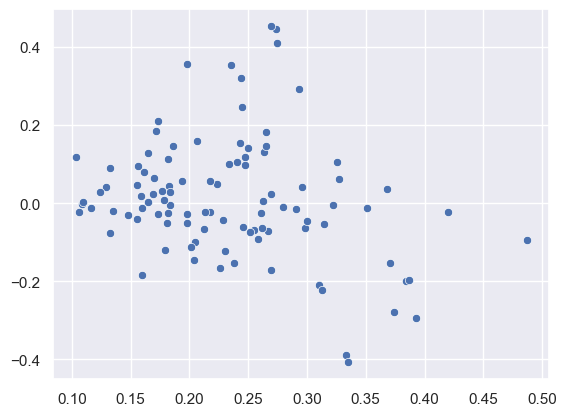

In [15]:
sns.scatterplot(x=subreddits_svd[:, 0], y=subreddits_svd[:, 1])

This looks like a more interesting shape? I think? It's kinda hard to tell... maybe there are some clusters here? I'll start with LDA since that seemed to work pretty well last time.

In [16]:
num_topics = 8

lda_model = LatentDirichletAllocation(n_components=num_topics, max_iter=5, learning_method='online',
                                      learning_offset=50.,random_state=0).fit(subreddits_tfidf)

display_topics(lda_model, vectorizer2.get_feature_names_out(), 10)

Topic 0:
chris tradition vacation partnership nicely reached chin gpa tinder grass
Topic 1:
warranty douche youngest crock messi na arrest alabama bankruptcy dealer
Topic 2:
trends susan 48 claims supporter mashed 1440p courage gg ethical
Topic 3:
rhinos freshman competitors filing clarify flawless asf medusa poles cape
Topic 4:
spez turtle socialism mixing evolution lion console nooooo doubts balloon
Topic 5:
painting recover trained bills translated afroman homelessness kittens screamed tile
Topic 6:
mods apps hank adorable pin esque utah cab initial senior
Topic 7:
moldy weight fomo prevented brightness ss aunt bruce fundamental takeout


...nope those still aren't really coherent at all, maybe NMF will fare better.

In [17]:
nmf_model = NMF(n_components=num_topics, random_state=0, l1_ratio=0.5, init="nndsvd").fit(subreddits_tfidf)

display_topics(nmf_model, vectorizer2.get_feature_names_out(), 10)

Topic 0:
therapist therapy dolly rhino teacher obese mattress cops hospital gun
Topic 1:
cats adorable kitty savevideo sea fish geese giphy elephant puppy
Topic 2:
spez mods apps users apollo buttons subs rif api cancel
Topic 3:
crypto bitcoin btc bank robinhood banks wsb trading img tax
Topic 4:
trump republicans court thomas supreme gop president republican indicted fox
Topic 5:
tattoo gorgeous stunning painting wallpaper turtle portrait album mountains artwork
Topic 6:
pizza delicious cheese cake sauce rice pepperoni bbq recipe sprouts
Topic 7:
nato russia ukraine finland putin pis poland russian sweden rodgers


Oh wow these topics look a lot more like what I was looking for! Let's take a closer look at what's inside.

In [18]:
def display_topics3(H, W, feature_names, docs, num_top_words, num_top_docs):
    topic_names = []
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        name = " ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]])
        topic_names.append(name)
        print(name)
        print('--------')
        top_doc_indices = np.argsort(W[:, topic_idx])[::-1][0:num_top_docs]

        # build list for frequency distribution
        for doc_index in top_doc_indices:
            print(docs.loc[doc_index].subreddit)
        print('----------------------------------------------')

    return topic_names


nmf_W = nmf_model.transform(subreddits_tfidf)    # topics-to-documents matrix
nmf_H = nmf_model.components_           # word-to-topics matrix
feat_names = vectorizer2.get_feature_names_out()

# print top words, top-1 document from each topic
topic_names = display_topics3(nmf_H, nmf_W, feat_names, subreddits, 10, 5)

Topic 0:
therapist therapy dolly rhino teacher obese mattress cops hospital gun
--------
Parenting
AskReddit
relationship_advice
Documentaries
Futurology
----------------------------------------------
Topic 1:
cats adorable kitty savevideo sea fish geese giphy elephant puppy
--------
cats
aww
AnimalsBeingDerps
AnimalsBeingBros
AnimalsBeingJerks
----------------------------------------------
Topic 2:
spez mods apps users apollo buttons subs rif api cancel
--------
technology
programming
videos
cars
AdviceAnimals
----------------------------------------------
Topic 3:
crypto bitcoin btc bank robinhood banks wsb trading img tax
--------
Bitcoin
wallstreetbets
CryptoCurrency
personalfinance
mildlyinteresting
----------------------------------------------
Topic 4:
trump republicans court thomas supreme gop president republican indicted fox
--------
politics
news
AdviceAnimals
nottheonion
Jokes
----------------------------------------------
Topic 5:
tattoo gorgeous stunning painting wallpape

These all make sense! Topic 0 seems to be where stuff that doesn't really fit anywhere else goes. I'm also curious about how r/mildlyinteresting ended up in the bitcoin category. Let's flip it around and look at the topic weights of individual subreddits. 

## Plotting Topics

Let's define a function to make a bar chart of a subreddit's topic weights

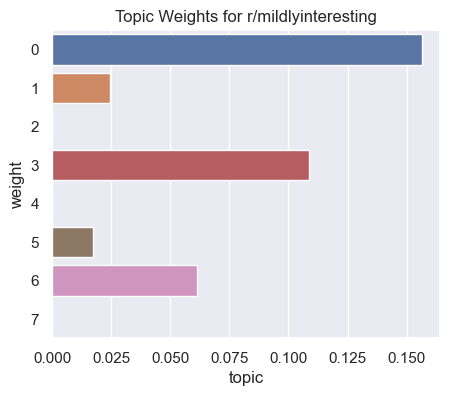

In [19]:
def plot_topics(sub, subreddits, W, size=(5,4)):
    f, ax = plt.subplots(figsize=size)
    idx = subreddits[subreddits.subreddit == sub].index
    plot = sns.barplot(W[idx], orient="h")
    plot.set_xlabel("topic")
    plot.set_ylabel("weight")
    plot.set_title(f"Topic Weights for r/{sub}")
    plt.show()


plot_topics("mildlyinteresting", subreddits, nmf_W)

Ah, looks like r/mildly interesting is primarily topic 0 (the topic that seems to be a weird general category), but has enough weight in the bitcoin category that it makes it into the top few in that category. What does something like r/Bitcoin that neatly falls into a topic look like?

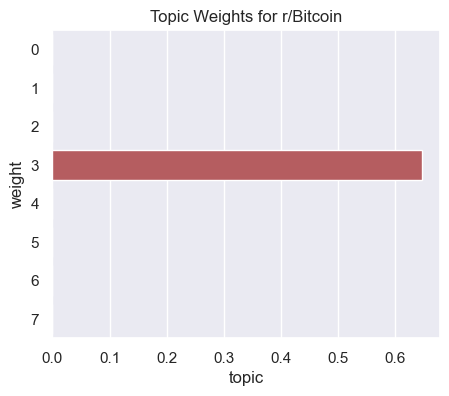

In [20]:
plot_topics("Bitcoin", subreddits, nmf_W)

Ah, a high weight in that specific category!

## Cluster Analysis

Now let's try analyzing the data within the clusters. To start, we can add a topic column with the index of the subreddit's highest weight topic.

In [21]:
subreddits["topic"] = np.argmax(nmf_W, axis=1)
subreddits.head()

,subreddit,text,total_tokens,avg_tokens,ttr,avg_word_len,topic
0,AdviceAnimals,Why bother even doing an AMA if they are only ...,34504,25.615442,0.903857,3.970445,2
1,AnimalsBeingBros,The rescue worker fireman said:\n\n> We rescue...,21064,13.704619,0.946698,4.153795,1
2,AnimalsBeingDerps,I love how he picked up on her concern when he...,29333,14.357807,0.939272,4.087738,1
3,AnimalsBeingJerks,I’ve long wondered how many hauntings really s...,15235,15.952880,0.933901,4.046530,1
4,Art,That land shark behind it is looking for its n...,21498,18.111205,0.931172,3.847400,5


Now how many do we have in each topic?

In [22]:
subreddits.topic.value_counts()

topic
0    36
2    16
1    14
5    11
6     7
4     7
7     5
3     4
Name: count, dtype: int64

Well, every topic has something but those bottom 4 topics barely have anything! the lowest is topic 3 (bitcoin), with only 4 subreddits! Lets try some statistical tests...

In [23]:
stats.f_oneway(
    subreddits[subreddits.topic == 0].avg_tokens,
    subreddits[subreddits.topic == 1].avg_tokens,
    subreddits[subreddits.topic == 2].avg_tokens,
    subreddits[subreddits.topic == 3].avg_tokens,
    subreddits[subreddits.topic == 4].avg_tokens,
    subreddits[subreddits.topic == 5].avg_tokens,
    subreddits[subreddits.topic == 6].avg_tokens,
    subreddits[subreddits.topic == 7].avg_tokens,
)

F_onewayResult(statistic=0.6930549152597067, pvalue=0.6776894577443765)

Well, I guess there's no correlation there. I want to do more analysis of these clusters, but I'm running out of time, so that will have to wait!

## Big Data

As a final bonus, let's try playing with the really big dataset! We can just do the same steps as in [Clustering Subreddits](#clustering-subreddits) to start.

In [24]:
comments_2500 = pd.read_pickle("../private/top_2500_processed.pkl")
comments_2500.head()

,subreddit,comment_id,text,tokens,num_tokens,num_types,ttr,avg_word_len
0,funny,jg3d9yg,"""Oh my god! That's awful!"" Exactly how you wan...","[``, Oh, my, god, !, That, 's, awful, !, '', E...",24,22,0.916667,3.250000
1,funny,jg3af9r,Her eyes when he stood up.,"[Her, eyes, when, he, stood, up, .]",7,7,1.000000,3.000000
2,funny,jg3782t,the reporter's name is Brad Blanks,"[the, reporter, 's, name, is, Brad, Blanks]",7,7,1.000000,4.142857
3,funny,jg39vhb,**Jennifer:** What are you getting in the way-...,"[*, *, Jennifer, :, *, *, What, are, you, gett...",19,16,0.842105,2.526316
4,funny,jg36sqa,They “were scared…of my brutish height.” 😂,"[They, “, were, scared…of, my, brutish, height...",9,9,1.000000,4.000000


In [25]:
subreddits_2500 = comments_2500[["subreddit", "text", "num_tokens", "num_types", "ttr", "avg_word_len"]].groupby("subreddit").agg(
    subreddit=("subreddit", "first"),
    text=("text", "\n".join),
    total_tokens=("num_tokens", "sum"),
    avg_tokens=("num_tokens", "mean"),
    ttr=("ttr", "mean"),
    avg_word_len=("avg_word_len", "mean"),
).reset_index(drop=True)
subreddits_2500.head()

,subreddit,text,total_tokens,avg_tokens,ttr,avg_word_len
0,100yearsago,"This is a view from Fargate, which is adjacent...",5768,23.834711,0.932802,4.077236
1,13or30,She looks like a mouse \n\nLike a really sad m...,17398,12.773862,0.953796,3.913302
2,15minutefood,[https://www.recipetineats.com/sizzling-ginger...,20311,50.777500,0.840211,4.070796
3,196,Justice for Eden\n\nHer family is involved too...,13981,17.675095,0.938039,4.348719
4,197,this is the fate of those who get in the way o...,11614,13.395617,0.947090,4.334058


In [26]:
vectorizer3 = TfidfVectorizer(max_features=10000, min_df=2, max_df=0.5, stop_words="english")
subreddits_tfidf_2500 = vectorizer3.fit_transform(subreddits_2500.text)

<Axes: >

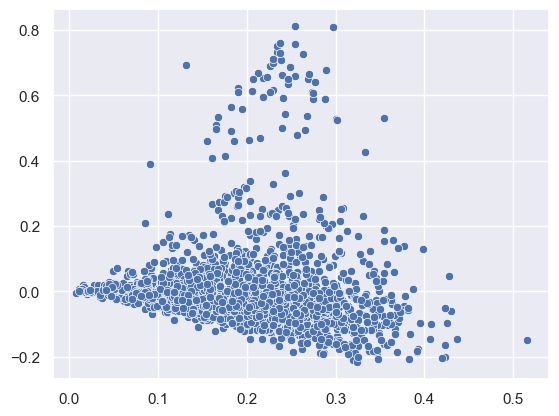

In [27]:
svd_model_2500 = TruncatedSVD(n_components=2)
subreddits_svd_2500 = svd_model_2500.fit_transform(subreddits_tfidf_2500)
sns.scatterplot(x=subreddits_svd_2500[:, 0], y=subreddits_svd_2500[:, 1])

Wow! there's actually obvious clusters this time!

In [28]:
num_topics = 16

nmf_model_2500 = NMF(n_components=num_topics, random_state=0, l1_ratio=0.5, init="nndsvd").fit(subreddits_tfidf_2500)

display_topics(nmf_model_2500, vectorizer3.get_feature_names_out(), 10)

Topic 0:
husband relationship sex daughter father trans partner gay married dating
Topic 1:
cat cats kitty adorable kitten dogs vet pet kittens cutie
Topic 2:
webp redd width preview pjpg format jpeg auto png gif
Topic 3:
income tax crypto debt market taxes bank government rent housing
Topic 4:
players player league map season pc steam gaming xbox gameplay
Topic 5:
hai bhai ke bhi ki ka india ko kya nahi
Topic 6:
cheese recipe sauce rice delicious chicken butter meat cook garlic
Topic 7:
ai app apps data windows linux code apple software users
Topic 8:
que el la es por se en pero lo los
Topic 9:
congratulations congrats weight gym birthday transformation inspiring progress journey training
Topic 10:
cars road truck driving fish driver bike savevideo park traffic
Topic 11:
gorgeous stunning painting colors lovely dress paint adorable talented artist
Topic 12:
album song songs spotify band albums artists bass guitar bands
Topic 13:
trump republicans biden vote gop republican government p

In [29]:
nmf_W_2500 = nmf_model_2500.transform(subreddits_tfidf_2500)    # topics-to-documents matrix
nmf_H_2500 = nmf_model_2500.components_           # word-to-topics matrix
feat_names = vectorizer3.get_feature_names_out()

# print top words, top-1 document from each topic
topic_names = display_topics3(nmf_H_2500, nmf_W_2500, feat_names, subreddits_2500, 10, 5)

Topic 0:
husband relationship sex daughter father trans partner gay married dating
--------
stories
relationship_advice
Parenting
love
AskParents
----------------------------------------------
Topic 1:
cat cats kitty adorable kitten dogs vet pet kittens cutie
--------
holdmycatnip
WhatsWrongWithYourCat
CatsBeingCats
cats
Catswhoyell
----------------------------------------------
Topic 2:
webp redd width preview pjpg format jpeg auto png gif
--------
whatismycookiecutter
DrawForMe
redditgetsdrawn
PhotoshopRequest
BeardedDragons
----------------------------------------------
Topic 3:
income tax crypto debt market taxes bank government rent housing
--------
eupersonalfinance
Economics
Fire
FinancialPlanning
CanadianInvestor
----------------------------------------------
Topic 4:
players player league map season pc steam gaming xbox gameplay
--------
gamedesign
gamingsuggestions
dndnext
PUBATTLEGROUNDS
outside
----------------------------------------------
Topic 5:
hai bhai ke bhi ki ka in

Where does r/pittsburgh fall in to all of this?

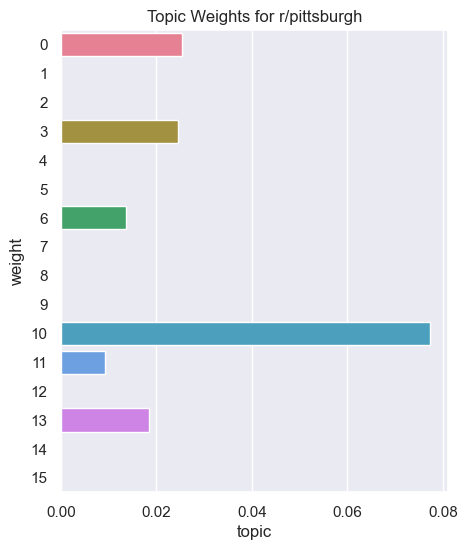

In [30]:
plot_topics("pittsburgh", subreddits_2500, nmf_W_2500, size=(5,6))

Of course, complaining about traffic. Finally, how many topics can we push this to?

In [31]:
num_topics = 64

nmf_model_2500 = NMF(n_components=num_topics, random_state=0, l1_ratio=0.5, init="nndsvd").fit(subreddits_tfidf_2500)

display_topics(nmf_model_2500, vectorizer3.get_feature_names_out(), 10)

Topic 0:
husband relationship daughter sex father partner parent married ex therapy
Topic 1:
cat cats kitty kitten adorable kittens vet kitties meow orange
Topic 2:
webp redd width preview pjpg format jpeg auto png 1080
Topic 3:
housing canada government prices rent inflation price trudeau canadians landlords
Topic 4:
xbox steam ps5 gaming console pc sony starfield dlc microsoft
Topic 5:
hai bhai ke bhi ki india ka kya nahi ko
Topic 6:
recipe rice sauce cheese chicken butter garlic cook pasta delicious
Topic 7:
jobs hr resume manager interview linkedin hiring boss career degree
Topic 8:
que el la es por se en pero lo los
Topic 9:
congratulations congrats accomplishment inspiring journey marathon achievement transformation inspiration race
Topic 10:
cars ferrari engine truck wheels ford rear tesla driving garage
Topic 11:
gorgeous stunning dress lovely adorable nails beauty colors makeup talented
Topic 12:
album song songs spotify band albums artists guitar bands bass
Topic 13:
trump re

These all seem genuinely very distinct and like cohesive topics! wow! Something to note is that non-english subreddits just end up getting classed by a bunch of function words since I only used english stop words.